## Unsupervised Learning with Linear Algebra

#### Importing packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import PIL
import urllib
from SVD import svd_reconstruct, read_image, to_greyscale, compare_images, svd_experiment

## Part 1: Image Compression with the Singular Value Decomposition

Singular Value Decomposition (SVD) is a factorization of some matrix A with the form  
$$A  = UDV^T$$
where $U \in \mathbb{R}^{mxm}$, $D \in \mathbb{R}^{mxn}$, and $V \in \mathbb{R}^{nxn}$. This specific factorization is so useful because we can approximate our initial matrix A by using a far smaller subset of information. In particular for some k, we can pull the first k columns of U, the first k rows of V, and the first k singular values of D to calculate our approximation of A. This is helpful in tasks such as image compression, where we may not have space to store such a large image and have to store a representative simplified image.

The goal of this post was to create a function which would take a SVD representation of an RGB image and reconstruct the image using an input value for k determining how many singular values to use. 

We first read in our image from a given url and  make the image a greyscale image.

In [2]:
url = "https://www.nj.com/resizer/lEQnc80MkcYWitSy3-_PLb4yON0=/1280x0/smart/cloudfront-us-east-1.images.arcpublishing.com/advancelocal/6VPZK7CRUJBFJM6G24CPF73ZAA.jpg"
img = read_image(url)
grey_img = to_greyscale(img)

We then create a reconstruction of our image, specifiying a given k.

In [3]:
reconstruction = svd_reconstruct(grey_img, 20)

We can then use the compare_images function to show the difference between our original image and the reconstructed, compressed image. The two images look side by side look like this:

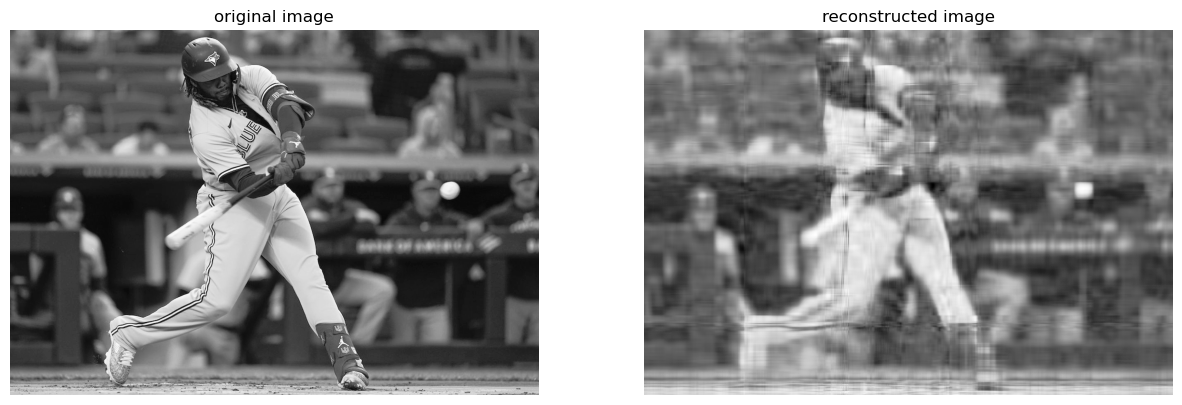

In [4]:
compare_images(grey_img, reconstruction)

Yikes! Not very good! Let's look at a few different values for k and see how this affects image quality. We would suspect that with a larger k value, and more values being stored, the compressed image will look more like the original image.

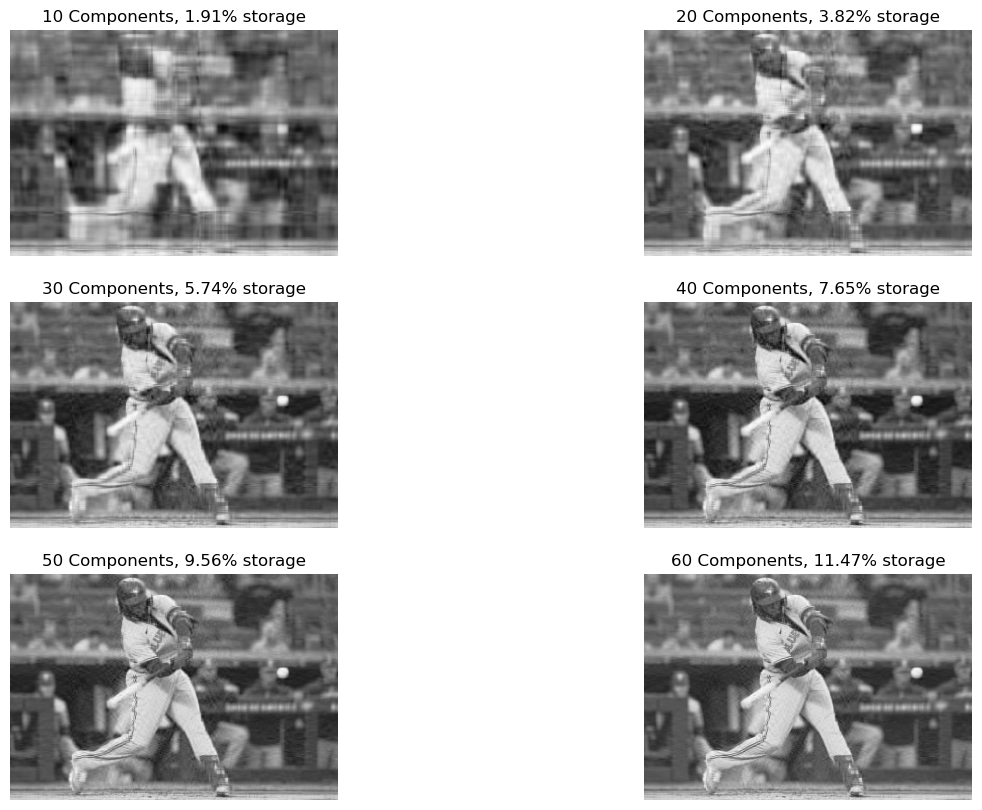

In [3]:
svd_experiment(grey_img)

Our hypothesis would be true! As the number of components increases, the image quality and storage necessary also increase! The final image, with 60 components, requires a little more than 10% of the storage initially required and most of the image's integrity remains.

## Part 2: Spectral Community Detection

In part 2 of this post, we are looking to implement spectral clustering on the Zachary's Karate Club dataset, comparing it to how the club actually divided. To do so, I wrote my own implementation of spectral clustering below. The process is as follows:

1) Take a graph object, get the adjacency matrix representation, and symmetrize it  

2) Create the degree matrix D by summing the amount of edges each node has and placing the value on the diagonal. 

3) Find the normalized laplacian of the form: $$L = D^{-1}(D-A)$$

4) Use the eigenvector of the second smallest eigenvalue to minimize the normcut objective

5) Use the sign of the values of this eigenvector to create the communities

In [17]:
import networkx as nx
import numpy as np

def spectral_clustering(G):
    
    # Get the adjacency matrix from the graph
    A = nx.adjacency_matrix(G).toarray()
    
    # Symmetrize the matrix
    A = A + A.T
    A[A > 1] = 1
    
    # Create our degree matrix D
    D = np.diag(np.sum(A, axis = 0))
    D1 = np.linalg.inv(D) # D inverse
    
    # Normalized laplacian
    L = D1@(D-A) 
    
    # Get eigenvalues and eigenvectors of L
    w, v = np.linalg.eig(L)
    
    # Get eigenvector of the second smallest eigenvalue
    z_ = v[:, 1]
    
    # Get the sign, use in clustering
    z = z_ > 0
    return z
    

We can then use this implementation to identify the two potential communities and plot the nodes colored by these choices. I used the circular layout simply for ease of analysis.

/var/folders/fl/5qx5y4sx03j07bk5cd1whd4c0000gn/T/ipykernel_9744/489024421.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).toarray()


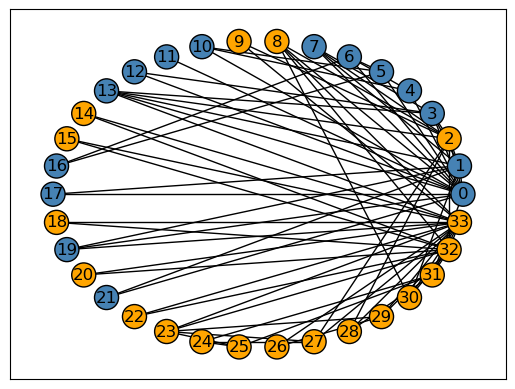

In [27]:
G = nx.karate_club_graph()
z = spectral_clustering(G)
layout = nx.layout.circular_layout(G)

nx.draw_networkx(G, layout,
        with_labels=True, 
        node_color = ["orange" if i == 1 else "steelblue" for i in z],
        edgecolors = "black" # confusingly, this is the color of node borders, not of edges
        ) 

Pretty cool! There is a clear divide eith about half of the nodes being tied to node 0 (Mr. Hi) and the other half tied to node 33 (Officer). To see how well my implementation did, we can compare its predictions to the actual divide. The true divide is plotted below, again with the circular layout for ease of use. 

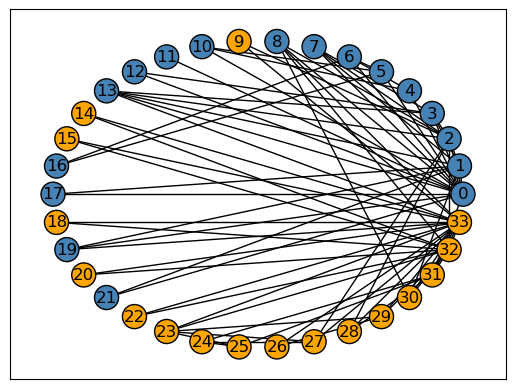

In [28]:
import networkx as nx
G = nx.karate_club_graph()
layout = nx.layout.circular_layout(G)


clubs = nx.get_node_attributes(G, "club")
nx.draw_networkx(G, layout,
        with_labels=True, 
        node_color = ["orange" if clubs[i] == "Officer" else "steelblue" for i in G.nodes()],
        edgecolors = "black" # confusingly, this is the color of node borders, not of edges
        ) 

They're almost the same! The only two points of contention are nodes 2 and 8. To better understand why these two points wre classified incorrectly, we can plot the nodes using the spring layout, which gives edges attractive forces and nodes repulsive forces, essentially positioning nodes with shared edges closer to each other.

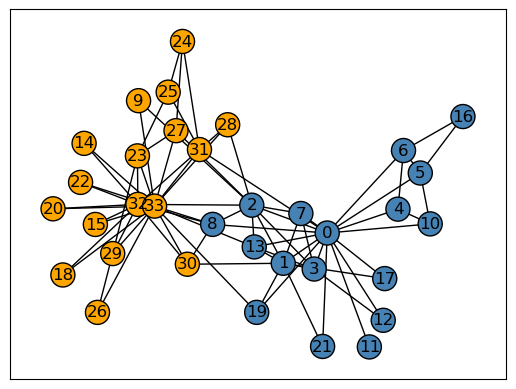

In [26]:
layout = nx.layout.spring_layout(G)


clubs = nx.get_node_attributes(G, "club")
nx.draw_networkx(G, layout,
        with_labels=True, 
        node_color = ["orange" if clubs[i] == "Officer" else "steelblue" for i in G.nodes()],
        edgecolors = "black" # confusingly, this is the color of node borders, not of edges
        ) 

By plotting the network in this manner, we can see that nodes 2 and 8 fall directly in the middle of the two main communities. This implies that these two individuals were almost equally likely to share edges and therefore be grouped into either community. Overall, our spectral community detection was successful and almost accurately identified every nodes related identity. 